# 1. Setup

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install pygam
# !pip install statsmodels
# !pip install plotly
# !pip install nbformat
# !pip install --upgrade nbformat
# !pip install ipykernel
# !pip install ggplot
# !pip install plotnine

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------- ----------------------- 3.4/8.1 MB 21.6 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 20.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 18.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 14.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ------------------- -------------------- 3.4/7.0 MB 18.5 MB/s eta 0:00:01
   ------------------------------------- -- 6.6/7.0 MB 15.7 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 14.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -------------- ------------------------- 3.1/8.7 MB 19.5 MB/s eta 0:00:01
   ------------------------------------- -- 8.1/8.7 MB 21.4 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 18.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---- ----------------------------------- 4.2/38.5 MB 20.7 MB/s eta 0:00:02
   --------- ------------------------------ 9.2/38.5 MB 21.4 MB/s eta 0:00:02
   ------------- -------------------------- 13.4/38.5 MB 21.2 MB/s eta 0:00:02
   ------------------ --------------------- 17.8/38.5 MB 20.9 MB/s eta 0:00:01
   ----------------------- ---------------- 22.3/38.5 MB 21.1 MB/s eta 0:00:01
   --------------------------- ------------ 26.7/38.5 MB 21.1 MB/s eta 0:00:01
   -------------------------------- ------- 30.9/38.5 MB 21.1 MB/s eta 0:00:01
 


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [181]:
# Data Wrangling
import pandas as pd
import numpy as np

# Modeling
from sklearn.preprocessing import LabelEncoder
from pygam import GAM, ExpectileGAM, s, l, f
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotnine import ggplot, aes, geom_ribbon, geom_line,facet_wrap,labs,theme,geom_point


In [69]:
df = pd.read_csv('../data/boxie60days.csv')
tags = pd.read_csv('../data/boxie_products.csv')

# 2. Data Engineering

handling data from no deal periods

In [140]:
df_tags = df.merge(
    tags, how='left', on='asin'
)

df_tags['event_name'] = np.where(
    df_tags['event_name'].isnull(),
    'NOT DEAL',
    df_tags['event_name']
)


df_tags['event_name'] = np.where(
    df_tags['event_name'].isnull(),
    'NOT DEAL',
    df_tags['event_name']
)

df_tags['event_year'] = np.where(
    df_tags['event_year'].isnull(),
    'NOT DEAL',
    df_tags['event_year']
)


df_tags['current_discount_percent'] = np.where(
    df_tags['current_discount_percent'].isnull(),
    0,
    df_tags['current_discount_percent']
)

df_tags = df_tags[df_tags['our_price']!=0]

# focus on topsellers
df_tags = df_tags[
    df_tags['Tag'].isin(['Unscented', 'Extra Strength', 'Probiotic'])
]

# add a product tag, + weight
df_tags['product'] = df_tags['Tag'] + ' ' + df_tags['weight_lb'].astype(str)


# 3. EDA

[Price Optimization with Generalized Additive Model (GAM) [Medium]](https://medium.com/@gustavorsantos/price-optimization-with-generalized-additive-model-gam-ed256d8e20f5)

focus on topsellers & assign tags

In [141]:

# aggregate
sales_df = df_tags[['asin','our_price', 'product', 'revenue_share_amt','shipped_units']].\
    groupby(['our_price', 'product']).\
    sum().reset_index()

## 3.1 Price vs Quantity Sold

In [194]:
fig = px.scatter(
    sales_df,
    x='our_price',
    y='shipped_units',
    log_y=True,
    color='product',
    width=1200,
    height=600,
    trendline='lowess', # used when the relationship is curved
    trendline_color_override='blue',
    title='Product Sales: Price vs Shipped Units' 
).update_traces(
    marker=dict(size=7)
).update_layout(
    legend_title_text='Product'
).update_xaxes(
    title_text='Price'
).update_yaxes(
    title_text='Shipped Units'
)

fig.show()

## 3.2 Event Analysis (Outliers)

In [198]:
df_tags = df_tags[
    df_tags['Tag'].isin(['Unscented', 'Extra Strength', 'Probiotic'])
]

# add a product tag, + weight
df_tags['product'] = df_tags['Tag'] + ' ' + df_tags['weight_lb'].astype(str)

# aggregate
sales_df = df_tags[['our_price', 'event_name', 'product', 'revenue_share_amt','shipped_units']].\
    groupby(['event_name', 'our_price', 'product']).\
    sum().reset_index()
sales_df

,event_name,our_price,product,revenue_share_amt,shipped_units
0,NOT DEAL,23.99,Probiotic 16.0,116975.24,4876
1,NOT DEAL,26.80,Unscented 6.5,294.80,11
2,NOT DEAL,27.99,Extra Strength 16.0,61214.13,2187
3,NOT DEAL,32.08,Unscented 6.5,64.16,2
4,NOT DEAL,32.73,Unscented 6.5,163.65,5
...,...,...,...,...,...
157,PRIME DAY,34.65,Unscented 28.0,34.65,1
158,PRIME DAY,34.95,Probiotic 28.0,34.95,1
159,PRIME DAY,35.30,Extra Strength 28.0,35.30,1
160,PRIME DAY,50.91,Unscented 40.0,50.91,1


In [199]:
fig = px.scatter(
    sales_df,
    x='our_price',
    y='shipped_units',
    facet_col='product',
    category_orders={
        "product": [
            'Unscented 6.5','Unscented 28.0', 'Unscented 40.0', 
            'Probiotic 16.0', 'Probiotic 28.0', 'Probiotic 40.0',
            'Extra Strength 16.0','Extra Strength 28.0', 'Extra Strength 40.0',  
        ]
    },
    facet_col_wrap=3,
    facet_col_spacing=0.1,
    facet_row_spacing=0.15,
    color='event_name',
    trendline='lowess',
    title='Product Sales: Event Analysis',
    width=1500,
    height=1000
).update_traces(
    marker=dict(size=7)
).update_layout(
    legend_title_text='Product',
    title_font=dict(size=16)
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10)
).update_yaxes(
    title_text='Shipped Units',
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

fig.update_xaxes(
    categoryorder='array', 
    categoryarray= [
        'Unscented 6.5','Unscented 28.0', 'Unscented 40.0', 
        'Probiotic 16.0', 'Probiotic 28.0', 'Probiotic 40.0',
        'Extra Strength 16.0','Extra Strength 28.0', 'Extra Strength 40.0',  
    ]
)
fig.update_layout(xaxis=dict(type='category'))

for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)

fig.for_each_xaxis(lambda axis: axis.update(showticklabels=True))
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))

fig.show()

## 3.4 Elasticity

Calculate the price elasticity of each of our products 
- % change in quantity demanded / % change in price
- Probiotic 28lb shows the highest elasticity (i.e., largest lift in units with each dollar price decreased)


In [147]:
# Calculating Price-Demand elasticity
elasticity = (
    df_tags
    .groupby('product')
    .agg({'our_price': ['max', 'min'],
          'shipped_units': ['max', 'min'],
          'product':'count'})
    .reset_index()
    .pipe(lambda d: d.set_axis(['product', 'our_price_max', 'our_price_min', 'shipped_units_max', 'shipped_units_min', 'product_count'], axis=1))
    .assign(pct_change_price=lambda d: (d['our_price_max'] - d['our_price_min']) / d['our_price_min'] * 100,
            pct_change_qty  =lambda d: (d['shipped_units_max'] - d['shipped_units_min']) / d['shipped_units_min'] * 100)
    .assign(
         ratio=lambda d: d['pct_change_qty'] / d['pct_change_price']) # demand elasticity
)

elasticity.sort_values(by='ratio',ascending=False).reset_index(drop=True)

,product,our_price_max,our_price_min,shipped_units_max,shipped_units_min,product_count,pct_change_price,pct_change_qty,ratio
0,Extra Strength 16.0,27.99,27.99,62,13,59,0.000000,376.923077,inf
1,Probiotic 16.0,23.99,23.99,140,17,59,0.000000,723.529412,inf
2,Probiotic 28.0,45.99,34.95,358,1,75,31.587983,35700.000000,1130.176630
3,Extra Strength 40.0,71.08,52.78,77,1,83,34.672224,7600.000000,219.195628
4,Unscented 28.0,48.17,34.65,81,1,74,39.018759,8000.000000,205.029586
5,Unscented 40.0,71.34,50.91,82,1,137,40.129641,8100.000000,201.845815
6,Probiotic 40.0,76.43,56.94,46,1,188,34.229013,4500.000000,131.467419
7,Extra Strength 28.0,50.47,35.30,35,1,58,42.974504,3400.000000,79.116678
8,Unscented 6.5,32.73,26.80,4,1,13,22.126866,300.000000,13.558179


In [211]:

fig = px.scatter(
    df_tags,
    x='our_price',
    y='shipped_units',
    facet_col='product',
    category_orders={
        "product": [
            'Unscented 6.5','Unscented 28.0', 'Unscented 40.0', 
            'Probiotic 16.0', 'Probiotic 28.0', 'Probiotic 40.0',
            'Extra Strength 16.0','Extra Strength 28.0', 'Extra Strength 40.0',  
        ]
    },
    facet_col_spacing=0.1,
    facet_row_spacing=0.15,
    facet_col_wrap=3,
    color='current_discount_percent',
    color_continuous_scale=px.colors.sequential.Oryel,
    trendline='lowess',
    title='Product Sales: Discount Analysis',
    width=1500,
    height=1000,
    template='plotly'
).update_traces(
    marker=dict(size=7)
).update_layout(
    legend_title_text='Product',
    title_font=dict(size=16)
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10)
).update_yaxes(
    title_text='Shipped Units',
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

fig.update_layout(xaxis=dict(type='category'))

for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)


fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True)) #show ticks
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True)) #show ticks
fig.update_yaxes(matches=None) # don't share y axis
fig.update_xaxes(matches=None) # don't share x axis

fig.show()


/Users/axiao/.pyenv/versions/3.8.18/envs/pricing-venv/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide


# 4. Modeling with GAM

- GAM assumes curvy (instead of linear) relationship
- curvy patterns <-- splines <--- smooth functions
- the prediction is made by adding up the effects of each variable — separately


In [152]:
data_filtered = df_tags[df_tags['event_name']=='NOT DEAL']

unique_prod = data_filtered['product'].unique()

all_gam_results = pd.DataFrame()

In [158]:
# Loop through products
for product in unique_prod:
    # Filter for current product
    product_data = data_filtered[data_filtered['product']==product]

    # Predictors & target split
    X = product_data[['our_price']]
    y = product_data['shipped_units']

    # List of quantiles for modeling
    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}

    # Fit the GAM model
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q) # instance the model
        gam.fit(X,y) #fit
        gam_results[f'pred_{q}'] = gam.predict(X) #predict for that quantile
        print(q, "|", product, "|", gam.deviance_residuals(X,y).mean())
    print("-----------\n")

    # Store the results in a DF
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)
    predictions_gam_df = pd.concat([product_data[['our_price', 'product','shipped_units']], predictions_gam], axis=1)
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis=0)

0.025 | Unscented 28.0 | 7.196567669452187
0.5 | Unscented 28.0 | 4.201235937526465e-09
0.975 | Unscented 28.0 | -7.222314940763293
-----------

0.025 | Extra Strength 16.0 | 14.702334808986894
0.5 | Extra Strength 16.0 | 1.616006901929075e-08
0.975 | Extra Strength 16.0 | -15.261434076230874
-----------

0.025 | Unscented 40.0 | 4.079664063836242
0.5 | Unscented 40.0 | 4.274677553105315e-09
0.975 | Unscented 40.0 | -8.354718407743363
-----------

0.025 | Probiotic 40.0 | 5.077651203916388
0.5 | Probiotic 40.0 | 1.8007679508303787e-10
0.975 | Probiotic 40.0 | -14.446953916462968
-----------

0.025 | Probiotic 28.0 | 24.652447515703866
0.5 | Probiotic 28.0 | -1.6279775989742857e-08
0.975 | Probiotic 28.0 | -30.944316442940213
-----------

0.025 | Probiotic 16.0 | 36.965353031544495
0.5 | Probiotic 16.0 | 3.6029486889258235e-08
0.975 | Probiotic 16.0 | -32.456977293244215
-----------

0.025 | Extra Strength 40.0 | 3.6507578708665105
0.5 | Extra Strength 40.0 | 3.391472154602963e-09
0.975

In [159]:
all_gam_results.sample(5)


,our_price,product,shipped_units,pred_0.025,pred_0.5,pred_0.975
808,69.75,Extra Strength 40.0,2,1.312352,4.021692,7.996567
1434,23.99,Probiotic 16.0,119,45.678715,82.644068,115.101045
1037,70.11,Probiotic 40.0,1,1.370605,5.457516,16.944856
1094,66.32,Unscented 40.0,1,1.291709,4.529507,12.528647
547,50.47,Extra Strength 28.0,4,1.448101,4.339623,9.341318


The next visualization is a way for us to assess if our model is getting most of the prices and quantities within the bands.



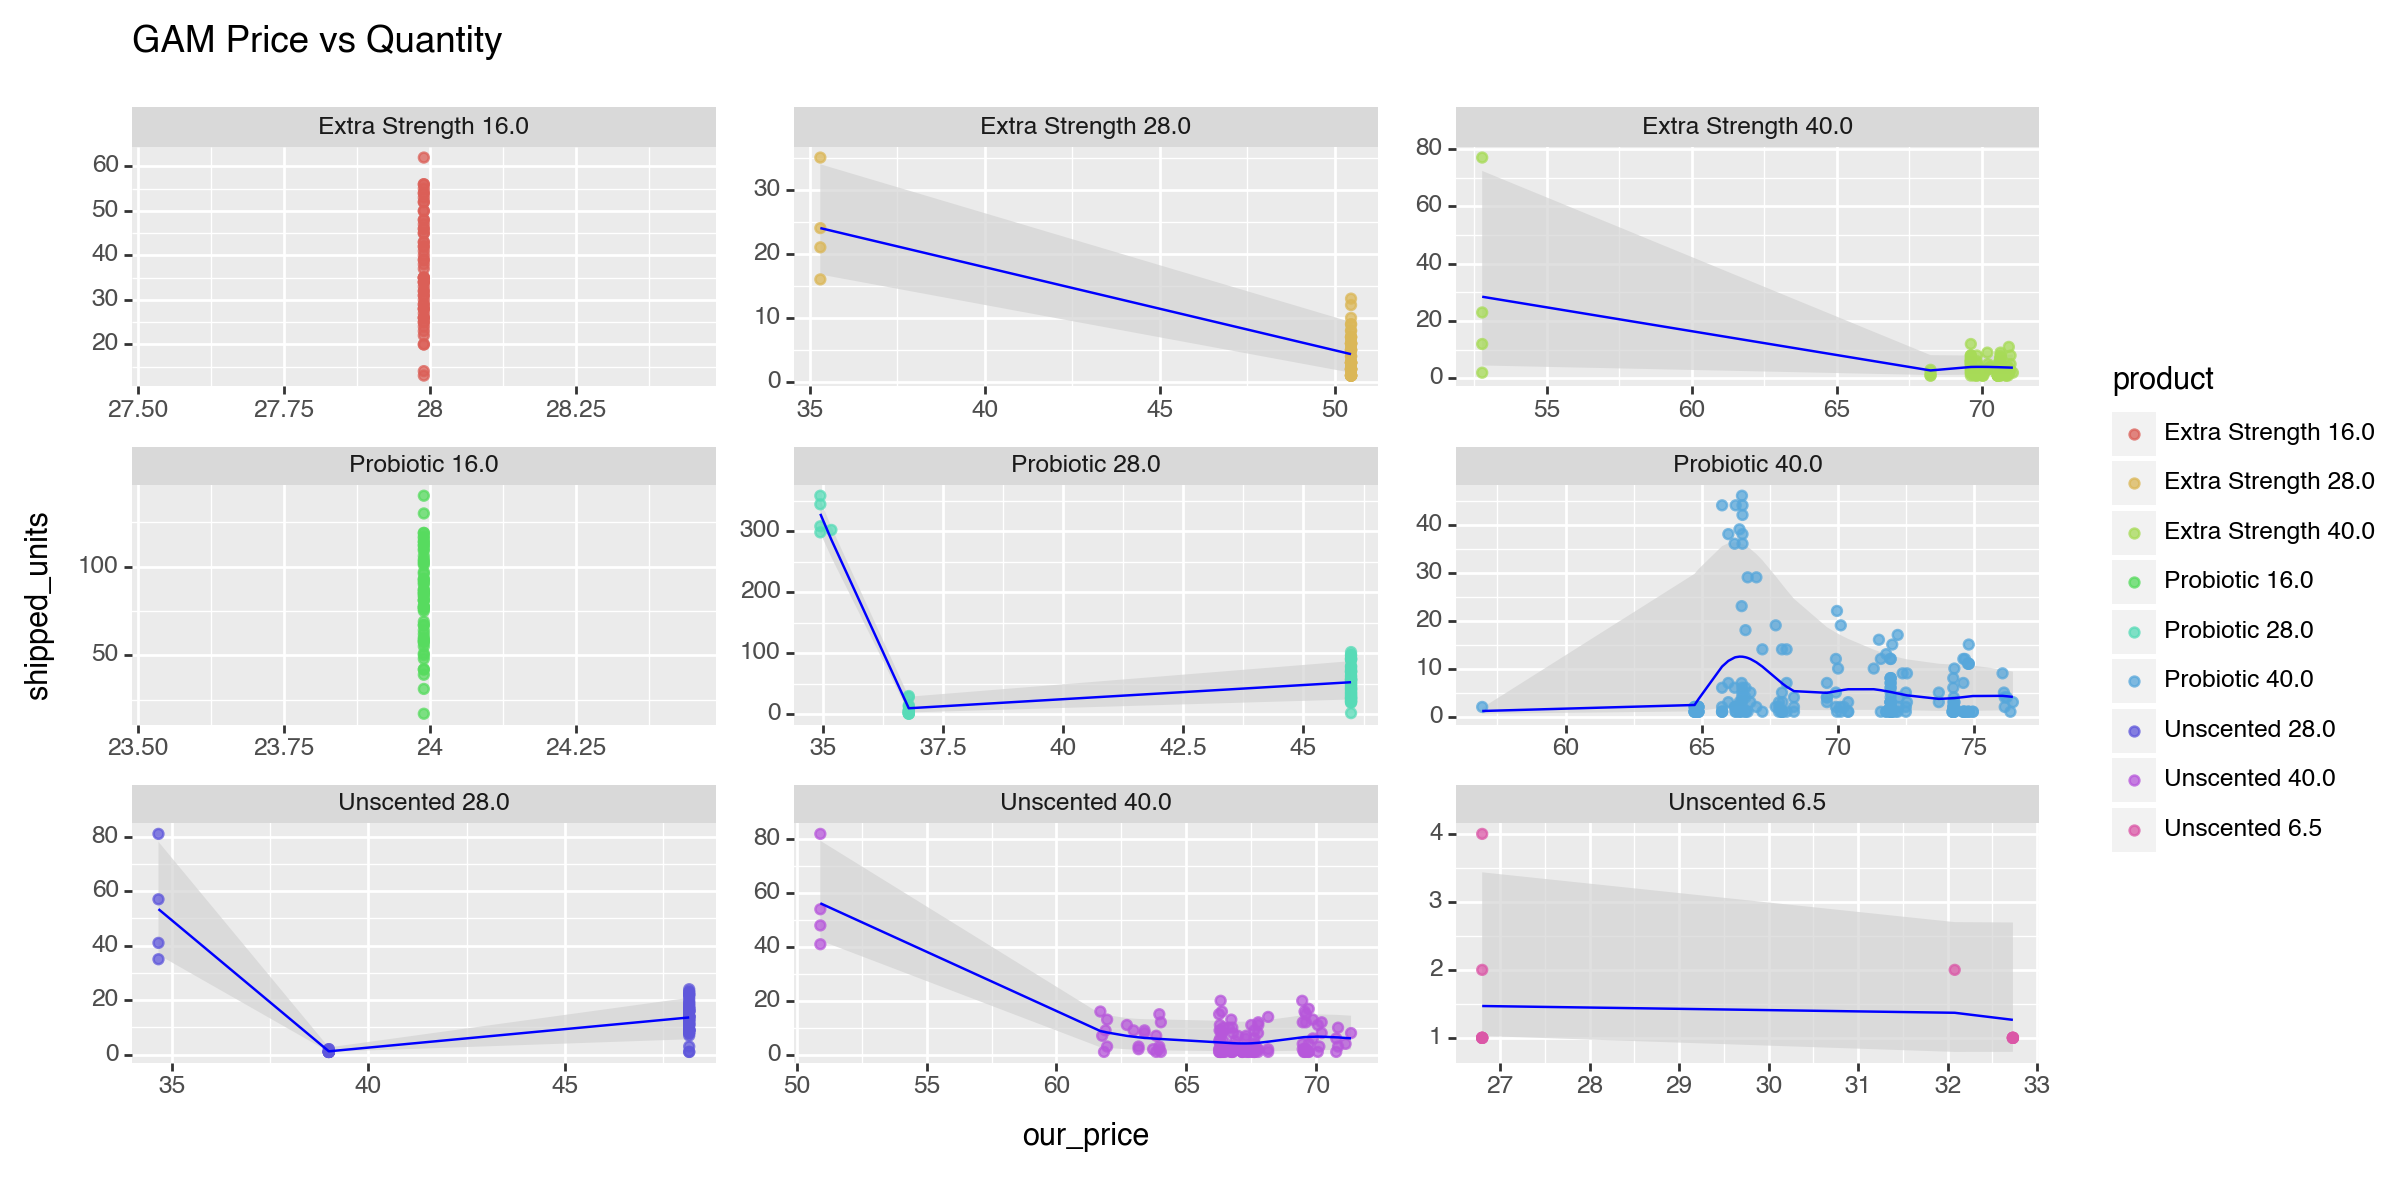

<Figure Size: (1200 x 600)>

In [188]:
# Visualization of the model and prices within the bands
(ggplot(
    data = all_gam_results,
    mapping = aes(x='our_price', y='shipped_units', color='product', group= 'product') ) +
    geom_ribbon(aes(ymax= 'pred_0.975', ymin= 'pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
    geom_point(alpha=0.75) +
    geom_line(aes(y='pred_0.5'), color='blue') +
    facet_wrap('product', scales='free') + 
    labs(title='GAM Price vs Quantity') +
    theme(figure_size=(12,6))
)

# 5. Optimize Price

In [189]:

# Calculate Revenue for each predicted price band
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_' + col] = all_gam_results['our_price'] * all_gam_results[col]

# Actual revenue
all_gam_results['revenue_actual'] = all_gam_results['our_price'] * all_gam_results['shipped_units']

# View
all_gam_results.sample(2)

,our_price,product,shipped_units,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
332,67.50,Unscented 40.0,1,1.222684,4.195423,12.278551,82.531183,283.191074,828.802215,67.50
269,38.99,Unscented 28.0,1,1.025447,1.217713,2.644966,39.982183,47.478639,103.127232,38.99


In [190]:
# Calculating where the predicted median revenue is the max
best_50 = (
    all_gam_results
    .groupby('product')
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 97.5% percentile revenue is the max
best_975 = (
    all_gam_results
    .groupby('product')
    .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 2.5% percentile revenue is the max
best_025 = (
    all_gam_results
    .groupby('product')
    .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1))
    .reset_index(level=0, drop=True)
)

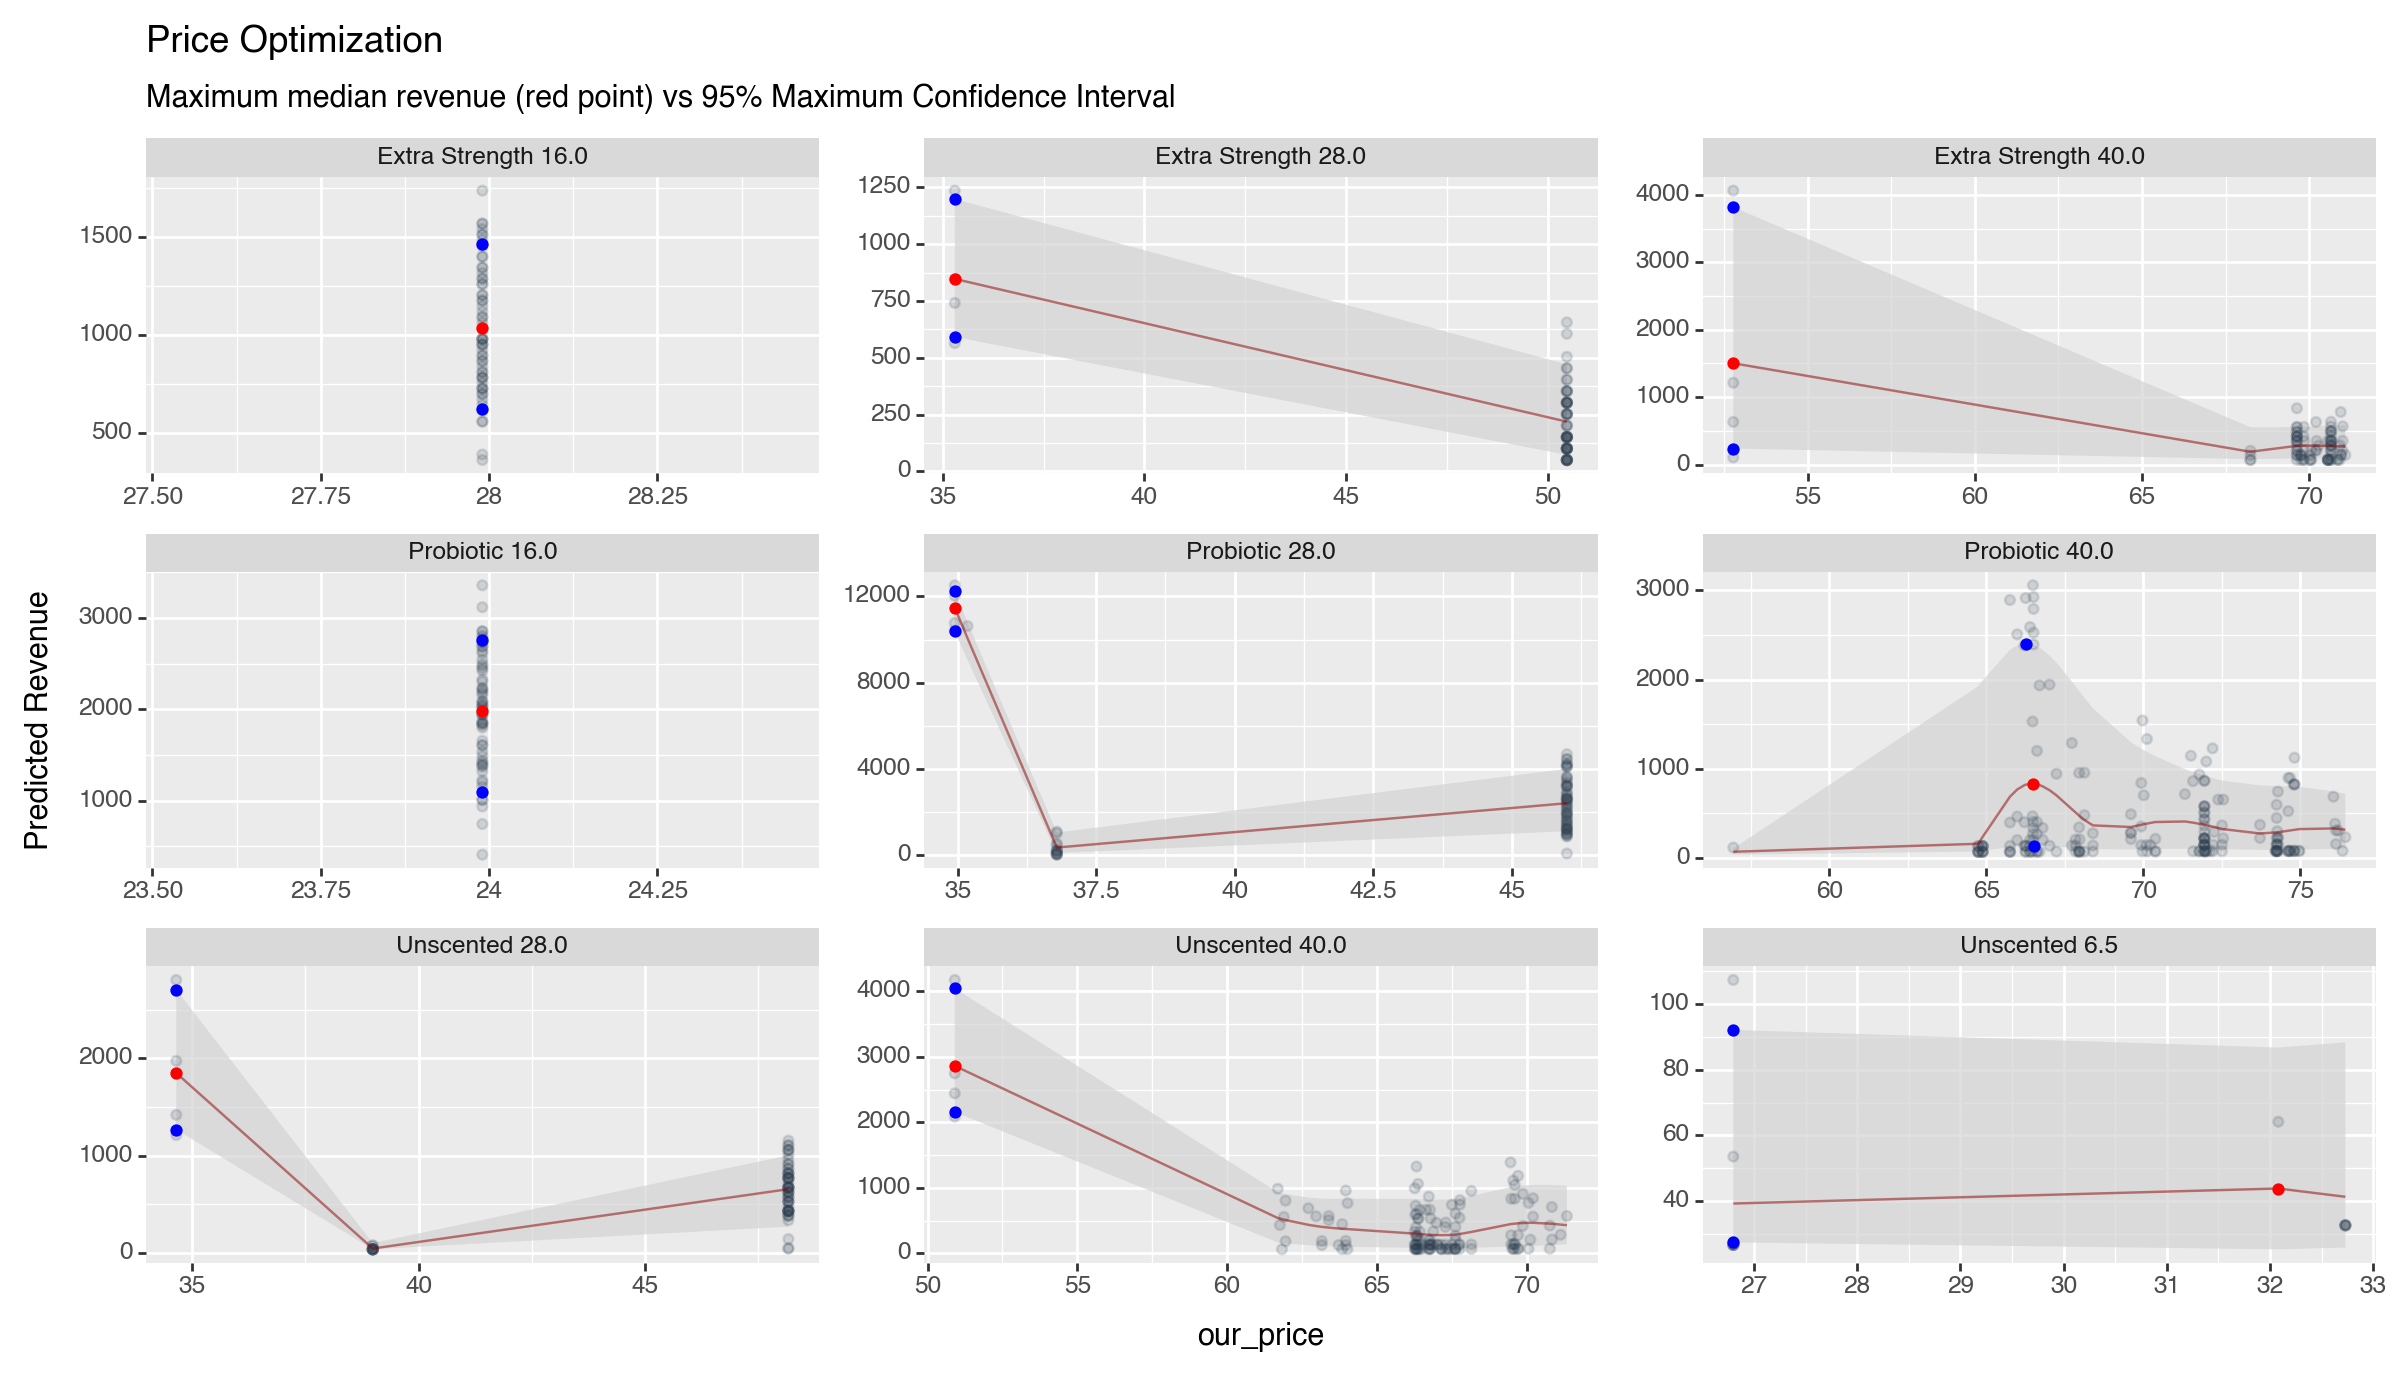

<Figure Size: (1200 x 700)>

In [191]:
# Visualize the GAM Optimization Result
(ggplot(
    # Data
    data = all_gam_results,
    # Axes
    mapping = aes(x='our_price', y='revenue_pred_0.5', color='product', group='product') ) + 
# Adding the Band
geom_ribbon(aes(ymax= 'revenue_pred_0.975', ymin= 'revenue_pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
# Adding the points
geom_point(aes(y='revenue_actual'), alpha=0.15, color="#2C3E50") +
# Adding 50th percentile line
geom_line(aes(y='revenue_pred_0.5'), alpha=0.5, color='darkred') +
# Addimg the 50th pct points
geom_point(data=best_50, color='red') + 
# Addimg the 97th pct points
geom_point(data=best_975, mapping= aes(y='revenue_pred_0.975'), color='blue') + 
# Addimg the 2.5th pct points
geom_point(data=best_025, mapping= aes(y='revenue_pred_0.025'), color='blue') + 
# Wraps by product
facet_wrap('product', scales='free') + 
# Labels
labs(
    title='Price Optimization',
    subtitle='Maximum median revenue (red point) vs 95% Maximum Confidence Interval',
    x= 'our_price',
    y= 'Predicted Revenue'
    ) +
theme(figure_size=(12,7))

)

In [193]:
# View optimum prices
best_50.reset_index(drop=True)


,our_price,product,shipped_units,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
0,27.99,Extra Strength 16.0,45,22.365462,37.067797,52.329231,626.009276,1037.527627,1464.695167,1259.55
1,35.30,Extra Strength 28.0,21,16.761904,24.000000,33.952380,591.695218,847.199986,1198.519014,741.30
2,52.78,Extra Strength 40.0,2,4.520068,28.484709,72.346140,238.569165,1503.422936,3818.429255,105.56
3,23.99,Probiotic 16.0,93,45.678715,82.644068,115.101045,1095.832367,1982.631186,2761.274072,2231.07
4,34.95,Probiotic 28.0,298,296.930626,328.299133,350.710084,10377.725376,11474.054695,12257.317439,10415.10
5,66.47,Probiotic 40.0,1,2.018602,12.480993,35.975062,134.176443,829.611625,2391.262357,66.47
6,34.65,Unscented 28.0,41,36.632971,53.396018,78.094163,1269.332456,1850.172037,2705.962745,1420.65
7,50.91,Unscented 40.0,82,42.382898,56.220227,79.448721,2157.713316,2862.171745,4044.734409,4174.62
8,32.08,Unscented 6.5,2,0.793146,1.368700,2.702322,25.444114,43.907898,86.690494,64.16
